In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

def mse(img1,img2):
    return np.mean((img1.astype("float")-img2.astype("float"))**2)

def psnr(img1,img2):
    mse_val=mse(img1,img2)
    if mse_val==0:
        return float('inf')
    return 20*math.log10(255.0/math.sqrt(mse_val))


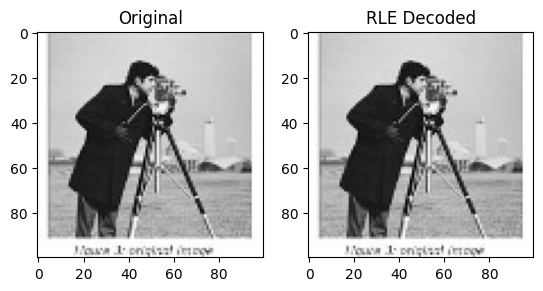

RLE Compression:
MSE: 0.0
PSNR: inf


In [2]:
img=cv2.imread("/content/CameraMan.jpg",cv2.IMREAD_GRAYSCALE)
def rle_encode(img):
    flat=img.flatten()
    encoded=[]
    prev=flat[0]
    count=1
    for i in flat[1:]:
        if i==prev:
            count+=1
        else:
            encoded.append((prev,count))
            prev=i
            count=1
    encoded.append((prev,count))
    return encoded

def rle_decode(encoded,shape):
    decoded=[]
    for val,count in encoded:
        decoded.extend([val]*count)
    return np.array(decoded,dtype=np.uint8).reshape(shape)

encoded=rle_encode(img)
decoded_rle=rle_decode(encoded,img.shape)

plt.subplot(121),plt.imshow(img,cmap='gray'),plt.title("Original")
plt.subplot(122),plt.imshow(decoded_rle,cmap='gray'),plt.title("RLE Decoded")
plt.show()

print("RLE Compression:")
print("MSE:",mse(img,decoded_rle))
print("PSNR:",psnr(img,decoded_rle))


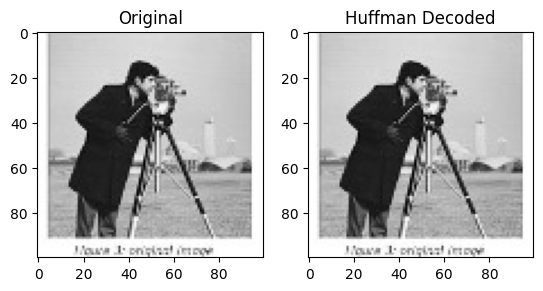

Huffman Compression:
MSE: 0.0
PSNR: inf


In [3]:
from heapq import heappush,heappop,heapify
from collections import defaultdict,Counter

class Node:
    def __init__(self,symbol,freq):
        self.symbol=symbol
        self.freq=freq
        self.left=None
        self.right=None
    def __lt__(self,other):
        return self.freq<other.freq

def build_huffman_tree(freqs):
    heap=[Node(sym,freq) for sym,freq in freqs.items()]
    heapify(heap)
    while len(heap)>1:
        l=heappop(heap)
        r=heappop(heap)
        new=Node(None,l.freq+r.freq)
        new.left=l
        new.right=r
        heappush(heap,new)
    return heap[0]

def build_codes(node,prefix='',codebook={}):
    if node:
        if node.symbol is not None:
            codebook[node.symbol]=prefix
        build_codes(node.left,prefix+'0',codebook)
        build_codes(node.right,prefix+'1',codebook)
    return codebook

# Encode
freqs=Counter(img.flatten())
tree=build_huffman_tree(freqs)
codes=build_codes(tree)

encoded=''.join([codes[p] for p in img.flatten()])

# Decode
reverse_code={v:k for k,v in codes.items()}
decoded=[]
code=""
for bit in encoded:
    code+=bit
    if code in reverse_code:
        decoded.append(reverse_code[code])
        code=""
decoded_huffman=np.array(decoded,dtype=np.uint8).reshape(img.shape)

plt.subplot(121),plt.imshow(img,cmap='gray'),plt.title("Original")
plt.subplot(122),plt.imshow(decoded_huffman,cmap='gray'),plt.title("Huffman Decoded")
plt.show()

print("Huffman Compression:")
print("MSE:",mse(img,decoded_huffman))
print("PSNR:",psnr(img,decoded_huffman))


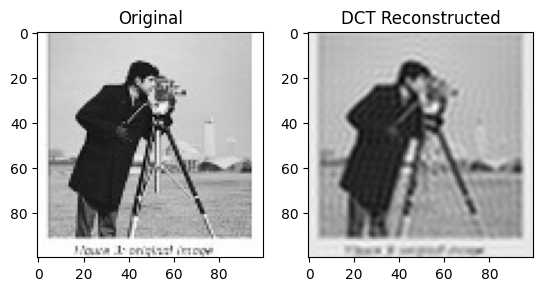

DCT Compression:
MSE: 307.0498446251527
PSNR: 23.258714789134622


In [4]:
def dct2(block):
    return cv2.dct(np.float32(block))

def idct2(block):
    return cv2.idct(block)

img_f=img.astype(np.float32)
dct_img=dct2(img_f)
# Keep only 50% coefficients
dct_img_filtered=dct_img.copy()
dct_img_filtered[50:,:]=0
dct_img_filtered[:,50:]=0
idct_img=idct2(dct_img_filtered)

plt.subplot(121),plt.imshow(img,cmap='gray'),plt.title("Original")
plt.subplot(122),plt.imshow(idct_img,cmap='gray'),plt.title("DCT Reconstructed")
plt.show()

print("DCT Compression:")
print("MSE:",mse(img,idct_img))
print("PSNR:",psnr(img,idct_img))


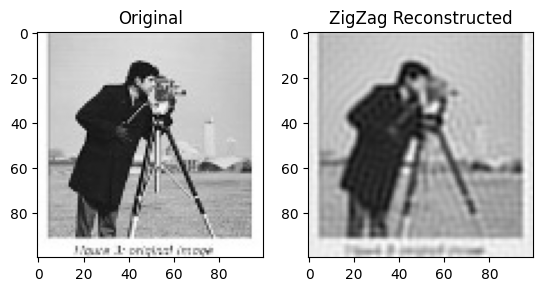

ZigZag Compression:
MSE: 327.72226508726686
PSNR: 22.975744129977084


In [5]:
def zigzag(input):
    h,w=input.shape
    result=[]
    for s in range(h+w-1):
        if s%2==0:
            for y in range(min(s,h-1),max(-1,s-w),-1):
                x=s-y
                result.append(input[y,x])
        else:
            for x in range(min(s,w-1),max(-1,s-h),-1):
                y=s-x
                result.append(input[y,x])
    return result

def inverse_zigzag(input,h,w):
    output=np.zeros((h,w),dtype=np.float32)
    index=0
    for s in range(h+w-1):
        if s%2==0:
            for y in range(min(s,h-1),max(-1,s-w),-1):
                x=s-y
                output[y,x]=input[index]
                index+=1
        else:
            for x in range(min(s,w-1),max(-1,s-h),-1):
                y=s-x
                output[y,x]=input[index]
                index+=1
    return output

# Apply DCT
dct_coeff=dct2(img_f)
zigzag_data=zigzag(dct_coeff)
# Keep only first N values
N=2000
truncated=np.array(zigzag_data[:N]+[0]*(len(zigzag_data)-N))
restored_dct=inverse_zigzag(truncated,img.shape[0],img.shape[1])
restored_img=idct2(restored_dct)

plt.subplot(121),plt.imshow(img,cmap='gray'),plt.title("Original")
plt.subplot(122),plt.imshow(restored_img,cmap='gray'),plt.title("ZigZag Reconstructed")
plt.show()

print("ZigZag Compression:")
print("MSE:",mse(img,restored_img))
print("PSNR:",psnr(img,restored_img))
